<a href="https://colab.research.google.com/github/Denev6/practice/blob/main/transformer/data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.8.15


In [ ]:
!pip install transformers

import nltk

nltk.download(
    ["punkt", "wordnet", "omw-1.4", "averaged_perceptron_tagger", "stopwords"]
)

In [ ]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import nltk.corpus
from nltk import pos_tag
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from google.colab import drive

drive.mount("/content/drive")

# Dataset

In [ ]:
TRAIN_CSV = os.path.join("/content/drive/MyDrive", "data", "train.csv")
train_csv = pd.read_csv(TRAIN_CSV)
utter = train_csv["Utterance"]

print("[Columns]")
print(*train_csv.columns.values, sep=", ")

[Columns]
ID, Utterance, Speaker, Dialogue_ID, Target


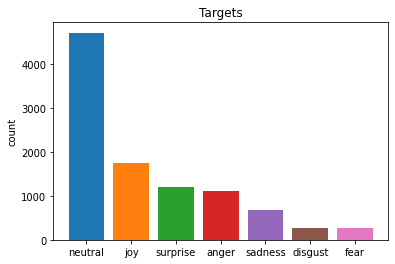

In [ ]:
targets = train_csv["Target"].value_counts()

for label, value in zip(targets.index, targets.values):
    plt.bar(label, value)
plt.title("Targets")
plt.ylabel("count")
plt.show()

In [ ]:
res = list()

for sent in utter.tolist():
    marks = re.findall(r"\W", sent)
    res += marks

print("[Special symbols]")
print(f" {' '.join(set(res))} ")

[Special symbols]
 ' ? * % . “ ’ & / — " : ‘ , – - ” … $ !   ] ( ; [ 


In [ ]:
sents = utter.map(lambda sent: str(sent).split()).map(len).tolist()
count = list(set(sents))
count.sort()

print("[Word count]")
for len_ in count[:5]:
    print(len_, end=" ")
print("... ", end="")
for len_ in count[-5:]:
    print(len_, end=" ")

print("\n")
print(f"- Median: {np.median(sents):.2f}")
print(f"- Mean: {np.mean(sents):.2f}")

[Word count]
1 2 3 4 5 ... 41 42 44 48 69 

- Median: 6.00
- Mean: 7.95


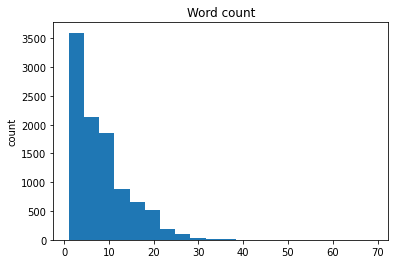

In [ ]:
plt.hist(sents, bins=20)
plt.title("Word count")
plt.ylabel("count")
plt.show()

# Utils

In [ ]:
class LabelEncoder(object):
    def __init__(self):
        self._targets = [
            "neutral",
            "joy",
            "surprise",
            "anger",
            "sadness",
            "disgust",
            "fear",
        ]
        self.num_classes = len(self._targets)

    def encode(self, label):
        return self._targets.index(label)

    def decode(self, label):
        return self._targets[label]

In [ ]:
class DataProcessor(object):
    def __init__(self, label_encoder):
        self._twt_tokenizer = TweetTokenizer(
            preserve_case=False, strip_handles=True, reduce_len=True
        )
        self._lemmatizer = WordNetLemmatizer()
        self._label_encoder = label_encoder
        self._regex_dict = {
            r"n\'t": " not",
            r"\'re": " are",
            r"\'s": " is",
            r"\'d": " would",
            r"\'ll": " will",
            r"\'ve": " have",
            r"\'m": " am",
            r"\'em": " them",
            r"y\'": "you ",
            r" *-+ *": " ",
            r"[:\$-\'\",\d]": "",
        }
        self._char_dict = {
            "–": "-",
            "—": "-",
            "“": '"',
            "”": '"',
            "‘": "'",
            "’": "'",
            "…": "...",
        }
        self._stop_word = nltk.corpus.stopwords.words("english")

    def process(self, data, has_label=False):
        data = data.reset_index(drop=True)
        data["Utterance"] = data["Utterance"].map(self._process)

        if has_label:
            data["Target"] = data["Target"].map(self._label_encoder.encode)
            data = data.loc[:, ["Utterance", "Target"]]
        else:
            data = data.loc[:, "Utterance"]
            data = data.to_frame()
        return data

    def _process(self, sentence):
        sentence = self.__unify_char(sentence)
        tokens = self._twt_tokenizer.tokenize(sentence)
        tokens = self.__remove_stop_word(tokens)
        tokens = self.__shorten_repeated_tokens(tokens)
        tokens = self.__remove_period_only(tokens)
        sentence = self.__sub_regex(tokens)
        sentence = self.__lemmatize(sentence)
        return sentence

    def __unify_char(self, sentence):
        for char, new in self._char_dict.items():
            sentence = sentence.replace(char, new)
        return sentence

    def __remove_stop_word(self, tokens):
        removed = [word for word in tokens if word not in self._stop_word]
        return removed

    def __shorten_repeated_tokens(self, tokens):
        for i, token in enumerate(tokens):
            if "-" in token:
                token = token.split("-")
                token = "-".join(dict.fromkeys(token))
                tokens[i] = token
        return tokens

    def __remove_period_only(self, tokens):
        if "." in tokens:
            tokens.remove(".")
        return tokens

    def __sub_regex(self, tokens):
        sentence = self.__tokens_to_sentence(tokens)
        for regex, word in self._regex_dict.items():
            sentence = re.sub(regex, word, sentence)
        return sentence

    def __lemmatize(self, sentence):
        tokens = sentence.split()
        token_tags = pos_tag(tokens)
        for i, token_tag in enumerate(token_tags):
            token, tag = token_tag
            if tag.startswith("VB"):
                tokens[i] = self._lemmatizer.lemmatize(token, pos="v")
            elif tag.startswith("N"):
                tokens[i] = self._lemmatizer.lemmatize(token, pos="n")
        sentence = self.__tokens_to_sentence(tokens)
        return sentence

    def __tokens_to_sentence(self, tokens):
        sentence = " ".join(tokens)
        marks = re.findall(r"\s\W\s*", sentence)
        for mark in marks:
            if mark.strip() == "'":
                sentence = sentence.replace(mark, mark.strip())
            else:
                sentence = sentence.replace(mark, mark.lstrip())
        return sentence

In [ ]:
class RoBERTaDataset(Dataset):
    def __init__(
        self,
        data,
        roberta_tokenizer,
        max_length=512,
        mode=None,
    ):
        self._roberta_tokenizer = roberta_tokenizer
        self._max_length = max_length
        self._mode = mode
        self._dataset = data

    def __len__(self):
        return len(self._dataset)

    def __getitem__(self, idx):
        text = self._dataset.loc[idx, "Utterance"]
        inputs = self._roberta_tokenizer(
            text,
            max_length=self._max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        input_ids = inputs["input_ids"][0]
        attention_mask = inputs["attention_mask"][0]

        if self._mode == "train":
            y = self._dataset.loc[idx, "Target"]
            return input_ids, attention_mask, y
        else:
            return input_ids, attention_mask

In [ ]:
label_encoder = LabelEncoder()
processor = DataProcessor(label_encoder)
roberta_tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

In [ ]:
encoded = label_encoder.encode("joy")

print("[Encode label]")
print(f"'joy' ->  {encoded}")

[Encode label]
'joy' ->  1


In [ ]:
sent1 = "AAAAAAWWWWWWWW!!!! Y'know.. I had 'em all!"
proc1 = processor._process(sent1)
sent2 = "The “World Cup” is a world festival."
proc2 = processor._process(sent2)

print("[Pre-process]")
print(f"\n-  {sent1}")
print(f"-> {proc1}")
print(f"\n-  {sent2}")
print(f"-> {proc2}")

[Pre-process]

-  AAAAAAWWWWWWWW!!!! Y'know.. I had 'em all!
-> aaawww!!! you know.. them!

-  The “World Cup” is a world festival.
-> world cup world festival


# How to use

In [ ]:
df_train, df_val = train_test_split(train_csv, test_size=0.2, shuffle=True)
print(f"Train: {df_train.shape}")
print(f"Eval: {df_val.shape}")

Train: (7991, 5)
Eval: (1998, 5)


In [ ]:
df_train = processor.process(df_train, has_label=True)
df_val = processor.process(df_val, has_label=True)

train_set = RoBERTaDataset(
    df_train,
    roberta_tokenizer,
    mode="train",
)
val_set = RoBERTaDataset(
    df_val,
    roberta_tokenizer,
    mode="train",
)

train_dataloader = DataLoader(train_set, batch_size=8)
val_dataloader = DataLoader(val_set, batch_size=8)